In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential  #모델 만들기
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D  #레이어 쌓기
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy, binary_crossentropy, mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Model

In [ ]:
(X_data,y_data), (tt_x, tt_y) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


데이터 확인

In [ ]:
#학습 데이터, 테스트 데이터의 차원 확인
X_data.shape, tt_x.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
X_data.max(), tt_x.max()
#데이터 스케일링을 위해 확인
#위에서 부호 없는 정수임을 알았으므로 음수가 없다. 고로 0부터 최댓값 255까지의 숫자로만 이루어져 있을 텐데 최댓값 255로 전부 나눠버리면 스케일링.

(255, 255)

In [ ]:
#학습 데이터, 테스트데이터의 내용 확인
X_data, tt_x
#unit8은 부호 없는 정수

In [ ]:
#학습 정답값, 테스트 정답값 차원 확인
y_data.shape, tt_y.shape

((60000,), (10000,))

In [ ]:
y_data, tt_y
#자료형은 x와 마찬가지로 정수형

(array([9, 0, 0, ..., 3, 0, 5], dtype=uint8),
 array([9, 2, 1, ..., 8, 1, 5], dtype=uint8))

In [ ]:
np.unique(y_data), np.unique(tt_y)
#정답의 유형 확인. 다중 클래스 분류임을 알았다.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [ ]:
s_t_x = X_data.reshape(-1,28,28,1) / 255.0
s_tt_x = tt_x.reshape(-1,28,28,1) / 255.0

In [ ]:
s_t_x.shape, s_tt_x.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

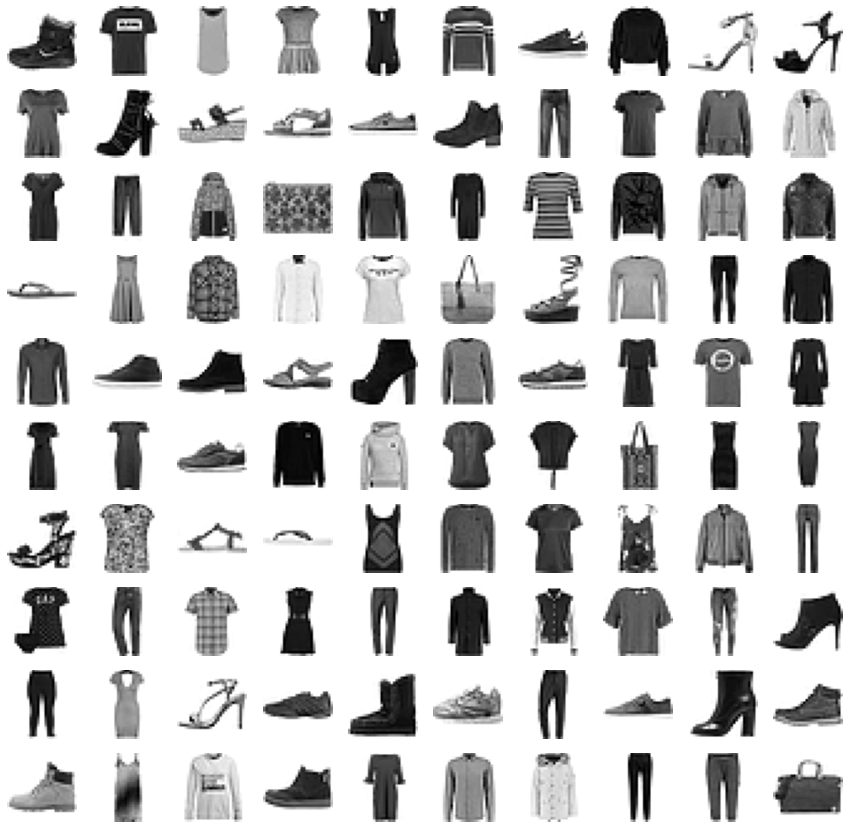

In [ ]:
fg, ax = plt.subplots(10,10, figsize= (15, 15))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(X_data[i*10 + j], cmap = 'gray_r')
        ax[i,j].axis('off')
plt.show()
#100개만 데이터 확인, 어떤 종류의 데이터들인지 시각화

In [ ]:
#그림에 맞는 정답 확인
for i in range(10):
    for j in range(10):
        print(y_data[i*10+j], end=' ')
    print()

9 0 0 3 0 2 7 2 5 5 
0 9 5 5 7 9 1 0 6 4 
3 1 4 8 4 3 0 2 4 4 
5 3 6 6 0 8 5 2 1 6 
6 7 9 5 9 2 7 3 0 3 
3 3 7 2 2 6 6 8 3 3 
5 0 5 5 0 2 0 0 4 1 
3 1 6 3 1 4 4 6 1 9 
1 3 5 7 9 7 1 7 9 9 
9 3 2 9 3 6 4 1 1 8 


In [ ]:
y_class = {0:'상의',1:'바지', 2:'긴팔상의', 3:'원피스',4:'점퍼', 5:'구두', 6:'셔츠', 7:'운동화', 8:'가방', 9: '신발'}

모델 생성

In [ ]:
#모델 생성
model = Sequential()

In [ ]:
#컨볼루션 층을 둘로 만들어봄
model.add(Conv2D(32,kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1))) #이미지
#커널(필터)의 개수 32, 사이즈(ex. 3이면 3*3 사이즈) 설정, 컨볼루션하고난 후의 이미지 크기 처리 방법padding 같게
#(높이, 너비, 채널(흑백 = 1, 색상RGB=3)) 정보 반드시 제공해야 한다.
model.add(MaxPooling2D(2)) #이미지
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')) #이미지
model.add(MaxPooling2D(2)) #이미지가 전달된다

#컨볼루션 층에 뉴런이 없다는 건 아니다. 필터 자체가 뉴런의 역할을 함.
#커널 사이즈를 (3)으로 하든 (3,3)으로 하든 큰 차이가 없다..?
# 다음 컨볼루션 층의 뉴런의 개수를 꼭 늘릴 필요는 없다. 
#풀링의 역할은 주요 이미지가 어디에 있든 접근을 할 수 있도록 공간의 제약을 낮추는 역할도 한다. + 차원 축소

In [ ]:
#뉴럴층
#따라서 무조건 dense 레이어를 쓰지 않아도 되긴 한다(?)
model.add(Flatten()) #입력층 레이어. 컨볼루션에서 받아줬으므로 차원 설정 x
#한 줄로 변경, 벡터화.  이미지를 값으로 바꿔준다고 생각하자.
model.add(Dense(100, activation='relu')) #값(숫자)
model.add(Dropout(0.3)) #0.3의 비율로 뉴런 안 쓰기. 값
model.add(Dense(10, activation='softmax')) #클래스 개수만큼의 출력, 다중클래스 분류니까 softmax. 값 전달. ouput 또한 숫자로 나온다.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [ ]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [ ]:
es = EarlyStopping(patience = 3, restore_best_weights=True)
ckp = ModelCheckpoint('bestM.h5')

In [ ]:
his = model.fit(X_data, y_data, validation_split=0.2, callbacks = [es, ckp], epochs= 100)
#너무 오래 걸리면 gpu세팅해서 학습하는 것도 방법

Epoch 1/100
1500/1500 [==============================] - 63s 42ms/step - loss: 0.4161 - accuracy: 0.8493 - val_loss: 0.3418 - val_accuracy: 0.8727
Epoch 2/100
1500/1500 [==============================] - 63s 42ms/step - loss: 0.3256 - accuracy: 0.8800 - val_loss: 0.3166 - val_accuracy: 0.8857
Epoch 3/100
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2929 - accuracy: 0.8921 - val_loss: 0.2759 - val_accuracy: 0.8988
Epoch 4/100
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2658 - accuracy: 0.9022 - val_loss: 0.2714 - val_accuracy: 0.9020
Epoch 5/100
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2487 - accuracy: 0.9082 - val_loss: 0.2747 - val_accuracy: 0.8992
Epoch 6/100
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2372 - accuracy: 0.9112 - val_loss: 0.3050 - val_accuracy: 0.9003
Epoch 7/100
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2235 - accuracy: 0.9157 - val_loss: 0

In [ ]:
his.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential  #모델a 만들기
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM  #레이어 쌓기
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy, binary_crossentropy, mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Model
from keras.utils.np_utils import to_categorical #일종의 원핫인코딩. 정답에 대한 내용들을 숫자로 바꾸겠다.

to_categorical

In [ ]:
(X_data,y_data), (tt_x, tt_y) = keras.datasets.fashion_mnist.load_data()

In [ ]:
np.unique(tt_y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
tt_y

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [ ]:
to_categorical(tt_y).shape

(10000, 10)

In [ ]:
tt_y.shape, y_data.shape

((10000,), (60000,))

In [ ]:
for i in range(10):
    print(tt_y[i], to_categorical(tt_y[i]), sep = '\n')
    print()


9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

2
[0. 0. 1.]

1
[0. 1.]

1
[0. 1.]

6
[0. 0. 0. 0. 0. 0. 1.]

1
[0. 1.]

4
[0. 0. 0. 0. 1.]

6
[0. 0. 0. 0. 0. 0. 1.]

5
[0. 0. 0. 0. 0. 1.]

7
[0. 0. 0. 0. 0. 0. 0. 1.]



In [ ]:
to_categorical(tt_y[1])
#???????

array([0., 0., 1.], dtype=float32)

In [ ]:
to_categorical(tt_y).shape

(10000, 10)

X

In [ ]:
X_data.dtype, X_data[0].dtype, X_data[0][0].dtype
#원래 숫자 데이터가 아니라 타입을 고쳐줄 것이다.

(dtype('uint8'), dtype('uint8'), dtype('uint8'))

In [ ]:
X_data = (X_data.reshape(-1, 28, 28, 1)).astype(float)/255.0 #이미지데이터를 처리할 때 반드시 한다.
tt_x = (tt_x.reshape(-1, 28, 28, 1)).astype(float)/255.0

In [ ]:
X_data.shape, tt_x.shape
#데이터 차원 확인

((60000, 28, 28, 1), (10000, 28, 28, 1))

Y

In [ ]:
y_data.shape
#정답값이 단일 데이터. 카테고리 데이터로 바꿔주려고 한다.
#+ 인풋과 아웃풋의 모양을 맞춰주려 한다..........

(60000,)

In [ ]:
y_data = to_categorical(y_data)
tt_y = to_categorical(tt_y)

In [ ]:
X_data.shape, tt_x.shape, y_data.shape, tt_y.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))

In [ ]:
m = Sequential()

In [ ]:
#컨볼루션 층을 둘로 만들어봄
m.add(Conv2D(32,kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1))) #이미지
#커널(필터)의 개수 32, 사이즈(ex. 3이면 3*3 사이즈) 설정, 컨볼루션하고난 후의 이미지 크기 처리 방법padding 같게
#(높이, 너비, 채널(흑백 = 1, 색상RGB=3)) 정보 반드시 제공해야 한다.
m.add(MaxPooling2D(2)) #이미지
m.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')) #이미지
m.add(MaxPooling2D(2)) #이미지가 전달된다
m.add(Conv2D(12, kernel_size=(3,3), activation='relu', padding='same')) #이미지
m.add(MaxPooling2D(2)) #이미지가 전달된다

#컨볼루션 층에 뉴런이 없다는 건 아니다. 필터 자체가 뉴런의 역할을 함.
#커널 사이즈를 (3)으로 하든 (3,3)으로 하든 큰 차이가 없다..?
# 다음 컨볼루션 층의 뉴런의 개수를 꼭 늘릴 필요는 없다. 
#풀링의 역할은 주요 이미지가 어디에 있든 접근을 할 수 있도록 공간의 제약을 낮추는 역할도 한다. + 차원 축소

#뉴럴층
#따라서 무조건 dense 레이어를 쓰지 않아도 되긴 한다(?)
m.add(Flatten()) #입력층 레이어. 컨볼루션에서 받아줬으므로 차원 설정 x
#한 줄로 변경, 벡터화.  이미지를 값으로 바꿔준다고 생각하자.
m.add(Dense(10, activation='softmax')) #클래스 개수만큼의 출력, 다중클래스 분류니까 softmax. 값 전달. ouput 또한 숫자로 나온다.
m.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 12)          6924      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 12)        

In [ ]:
m.compile(loss ='categorical_crossentropy', metrics='accuracy') #y데이터를 기준으로 loss를 선택하자. 
#loss의 역할: 오차를 계산하는 것. 예측값 - 실제값

In [ ]:
m.fit(X_data, y_data)

1875/1875 [==============================] - 84s 44ms/step - loss: 0.5374 - accuracy: 0.8065


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential  #모델a 만들기
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM  #레이어 쌓기
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy, binary_crossentropy, mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Model
from keras.utils.np_utils import to_categorical #일종의 원핫인코딩. 정답에 대한 내용들을 숫자로 바꾸겠다.

In [2]:
from keras.datasets import cifar10

In [3]:
(X_data,y_data), (tt_x, tt_y) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [4]:
X_data.shape, tt_x.shape, y_data.shape, tt_y.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

CNN 기반의 학습 <br>
정답을 원핫인코딩 방식으로 정리하여 모델을 학습하고 결과를 확인하자.

In [5]:
#정답 데이터 종류 보기
np.unique(y_data)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
y_data

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [6]:
tt_y

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [7]:
c_y_data = to_categorical(y_data)
c_y_data.shape

(50000, 10)

In [ ]:
c_y_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
c_tt_y = to_categorical(tt_y)
c_tt_y.shape, tt_y

((10000, 10), array([[3],
        [8],
        [8],
        ...,
        [5],
        [1],
        [7]], dtype=uint8))

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


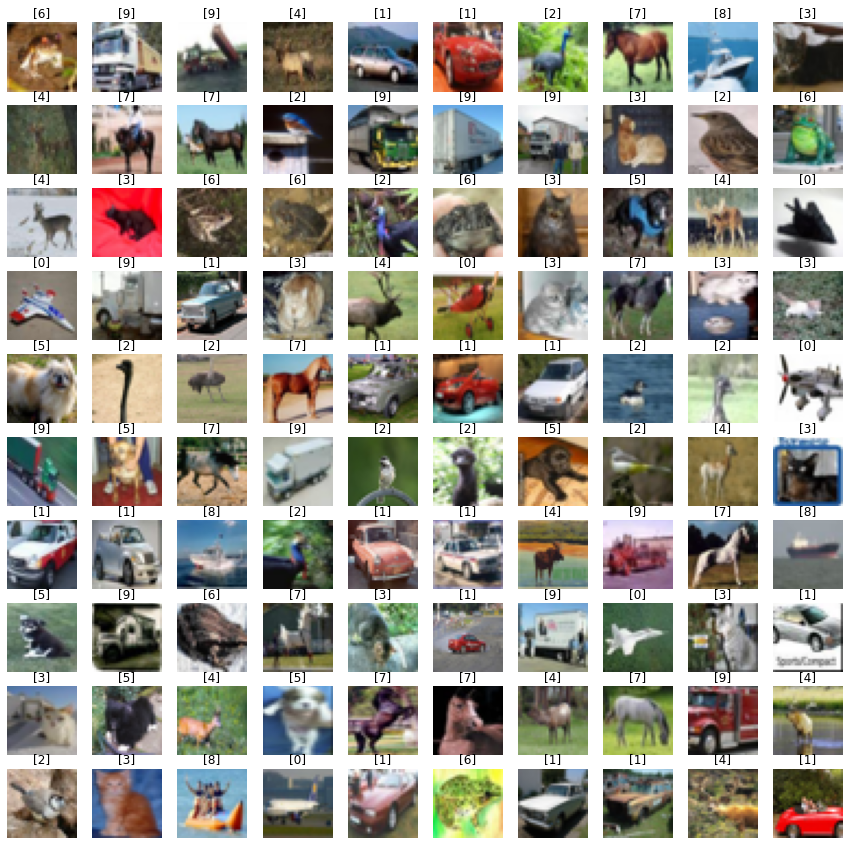

In [81]:
fg, ax = plt.subplots(10, 10, figsize = (15,15))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(X_data[i*10+ j])
        ax[i,j].axis('off')
        ax[i,j].set_title(y_data[i*10+j])
plt.show()

In [9]:
answer = {0:'비행기',1:'소형차',2:'새',3:'고양이',4:'사슴',5:'개',6:'개구리',7:'말',8:'보트',9:'대형차'}

In [10]:
s_t_x = X_data.astype(float) / 255.0
s_tt_x = tt_x.astype(float) / 255.0

In [ ]:
s_t_x

In [64]:
del m

In [65]:
m = Sequential()

In [66]:
m.add(Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = (32, 32, 3)))
m.add(MaxPooling2D(2))
m.add(Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'))
m.add(MaxPooling2D(2))
m.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
m.add(MaxPooling2D(2))
m.add(Conv2D(256, kernel_size = (3,3), activation = 'relu', padding = 'same'))
m.add(MaxPooling2D(2))
m.add(Flatten())
m.add(Dense)
m.add(Dense(10, activation='softmax'))
m.summary()
#컨볼루션은 부분부분 영역별로 가중치
#댄스는 픽셀 하나마다 전부 다 가중치

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)       

In [67]:
es = EarlyStopping(patience=5, restore_best_weights=True) #restore_best_weights는 내가 곧바로 제일 좋은 모델을 쓸 때 
ckp = ModelCheckpoint('best_m.h5') #모델을 저장해놓고 나중에도 쓸 때

In [68]:
m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [92]:
del his1

In [69]:
his1 = m.fit(s_t_x,c_y_data, validation_split=0.2, callbacks = [es, ckp], epochs=50)

Epoch 1/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.4522 - accuracy: 0.4701 - val_loss: 1.1735 - val_accuracy: 0.5830
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0083 - accuracy: 0.6437 - val_loss: 0.9834 - val_accuracy: 0.6594
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8122 - accuracy: 0.7151 - val_loss: 0.8431 - val_accuracy: 0.7080
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6729 - accuracy: 0.7638 - val_loss: 0.8082 - val_accuracy: 0.7245
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5572 - accuracy: 0.8041 - val_loss: 0.7886 - val_accuracy: 0.7373
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4498 - accuracy: 0.8427 - val_loss: 0.8374 - val_accuracy: 0.7300
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.3533 - accuracy: 0.8762 - val_loss: 0.8903 - val_accuracy:

In [89]:
his1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

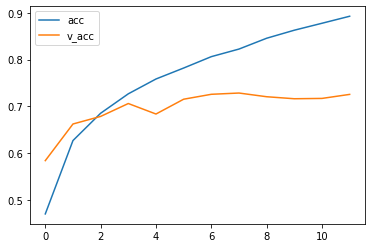

In [16]:
plt.plot(his1.history['accuracy'])
plt.plot(his1.history['val_accuracy'])
plt.legend(['acc','v_acc'])
plt.show()

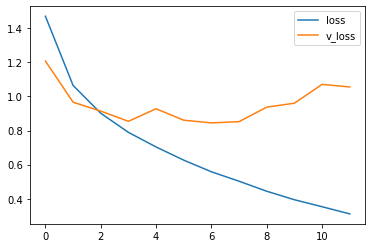

In [17]:
plt.plot(his1.history['loss'])
plt.plot(his1.history['val_loss'])
plt.legend(['loss','v_loss'])
plt.show()

In [18]:
from tensorflow.keras.models import load_model
new_m = load_model('best_m.h5') #저장한 모델을 그대로 불러옴

In [84]:
s_t_x.shape

(50000, 32, 32, 3)

In [19]:
#test_p = new_m.predict(s_t_x[:10])

In [ ]:
#test_p

In [ ]:
#test_p >0.4

In [ ]:
#c_y_data[:10]

In [45]:
#np.unique(y_data)[(test_p>0.5)[0]][0]

6

In [ ]:
#np.where(test_p>0.4, 1, 0) #참이면 1, 거짓이면 0

In [34]:
answer = {0:'비행기',1:'소형차',2:'새',3:'고양이',4:'사슴',5:'개',6:'개구리',7:'말',8:'보트',9:'대형차'}

In [79]:
def ans(xdata, n, m):
    y_p = new_m.predict(xdata[n:m]) >0.4
    j = 0
    for i in range(n, m):
        print(answer[(np.unique(y_data)[y_p[j]])[0]])
        plt.imshow(tt_x[i])
        plt.axis('off')
        j += 1
        plt.show()

보트


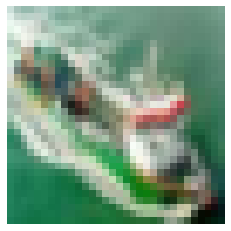

개


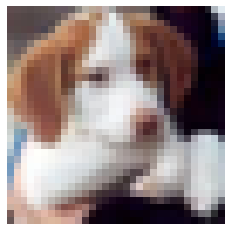

말


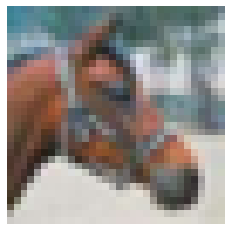

보트


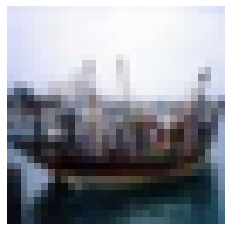

개구리


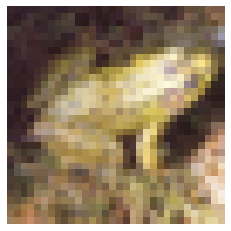

말


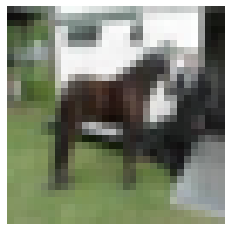

새


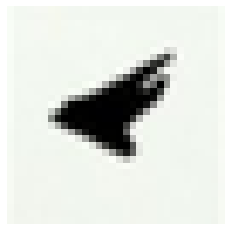

사슴


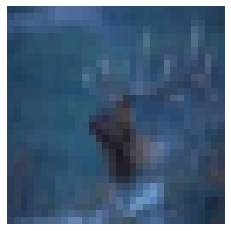

대형차


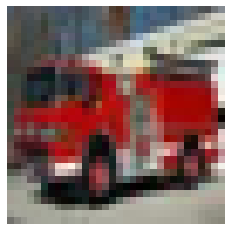

사슴


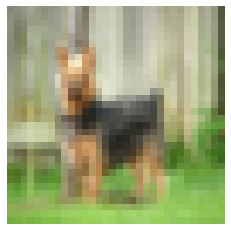

개구리


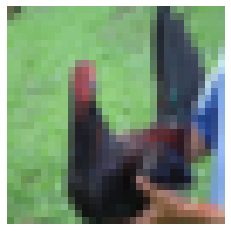

사슴


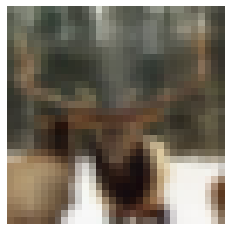

비행기


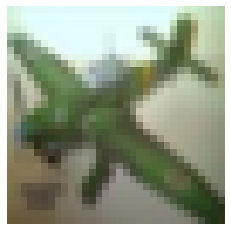

대형차


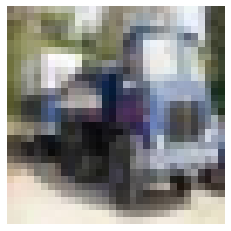

개구리


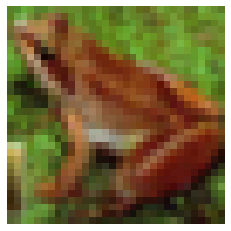

In [80]:
ans(s_tt_x, 15, 30)